In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import subsystem2 # import relevant, abstracted code
import math
from pprint import pprint
import copy

from timeit import default_timer as timer
import matplotlib.animation as animation
import time

import numpy as np
from statistics import mean
import random
random.seed(12345)
np.random.seed(12345)

notebook_start_time = timer()

plt.rcParams["font.family"] = "serif"
plt.rcParams["savefig.dpi"] = 150

def newfigure(*args, **kwargs):
    fig, ax = plt.subplots(*args, **kwargs)
    for i, a in enumerate(fig.axes):
        a.tick_params(direction='in', grid_linestyle=":", top=True, right=True)
        a.grid(which='major', axis='both', linestyle=":")
    return fig, ax

# Control Parameters

In [2]:
# global parameters
time_period = 60*60  # 60 minute total time period

# building properties
building_flr_h = 4.0  # distance in metres between floors
building_n_flr = 50  # number of floors in the building

# lift properties
lift_vmax = 5.0  # maximum velocity lift travels at
lift_acc  = 0.5  # acceleration/deceleration of lift
lift_dr_t = 3.0  # time to either open/close lift doors

# 1. Initial investigation

Firstly, using the output of the first subsystem, we can model the physical behaviour of the lift in order to determine travel times between floors.

Since the lift is being modelled with constant, or zero, acceleration/deceleration, we can fully derive these characteristics. The result of which has been coded into the `subsystem.py` python file.

The lift characteristics have been instantiated with fairly arbritrary parameters. This is in order to decouple the subsystem from subsystem 1. The main difference of altering these parameters is the required distance/time in order for a lift to reach maximum velocity.

The distance required to reach maximum velocity:     25.0
Number of floors required to reach maximum velocity: 6.25
The time taken to reach maximum velocity:            10.0
n =  1    Travel = 11.657 seconds
n =  2    Travel = 14.000 seconds
n =  3    Travel = 15.798 seconds
n =  4    Travel = 17.314 seconds
n =  5    Travel = 18.649 seconds


<IPython.core.display.Javascript object>


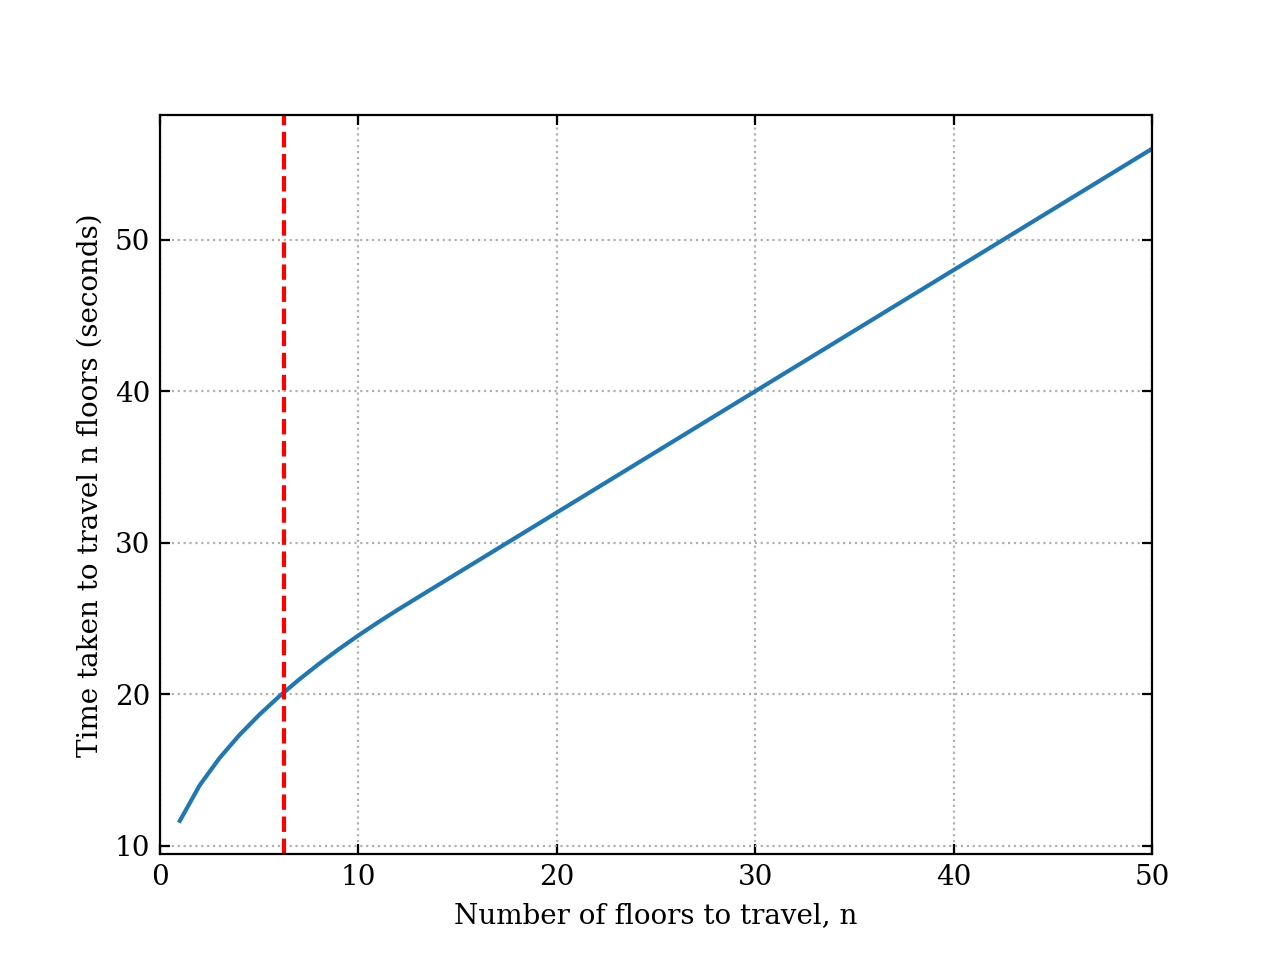

In [3]:
lift = subsystem2.Lift( vmax = lift_vmax, 
                        acc  = lift_acc, 
                        door_time    = lift_dr_t,
                        floor_height = building_flr_h)

print("The distance required to reach maximum velocity:     {:4}".format(lift.smv))
print("Number of floors required to reach maximum velocity: {:4}".format(lift.smv/lift.df))
print("The time taken to reach maximum velocity:            {:4}".format(lift.tmv))

ns = range(1, building_n_flr+1)
Ts = []
    
for n in ns:
    t = lift.travel_time(n)
    Ts.append(t)
    if n < 6:
        print("n = {0:2d}    Travel = {1:6.3f} seconds".format(n,t))


newfigure()
plt.plot(ns, Ts)
plt.axvline(x=lift.smv/lift.df, linestyle="--", color="red")
plt.ylabel("Time taken to travel n floors (seconds)")
plt.xlabel("Number of floors to travel, n")
plt.xlim(0, building_n_flr)
plt.show()
plt.savefig('output/floorsvtime.png')

The graph shows that beyond the threshold of reaching maximum velocity, the change in travel time simply scales linearly, as expected.

# Challenging Assumptions

A natural assumption for this system was that maximising the time spent at maximum velocity would ensure trips with multiple passengers would be a optimal as possible. Mainly, that this would be achieved through assigning passengers so target floors were as evenly spaced as possible.

To challenge and validate this assumption, a comparison was made between evenly spacing passengers on the same lift, and grouping passengers on the same lift to floors close to one another.

## Scenario 1

Two lifts. Four passengers, each going to floor 4,5,12,13 respectively. This scenario uses each lift to group passengers going to similar floors.

## Scenario 2

Two lifts. Four passengers, each going to floor 4,5,12,13 respectively. This scenario uses each lift to space out the floors passengers are being delivered.

<IPython.core.display.Javascript object>


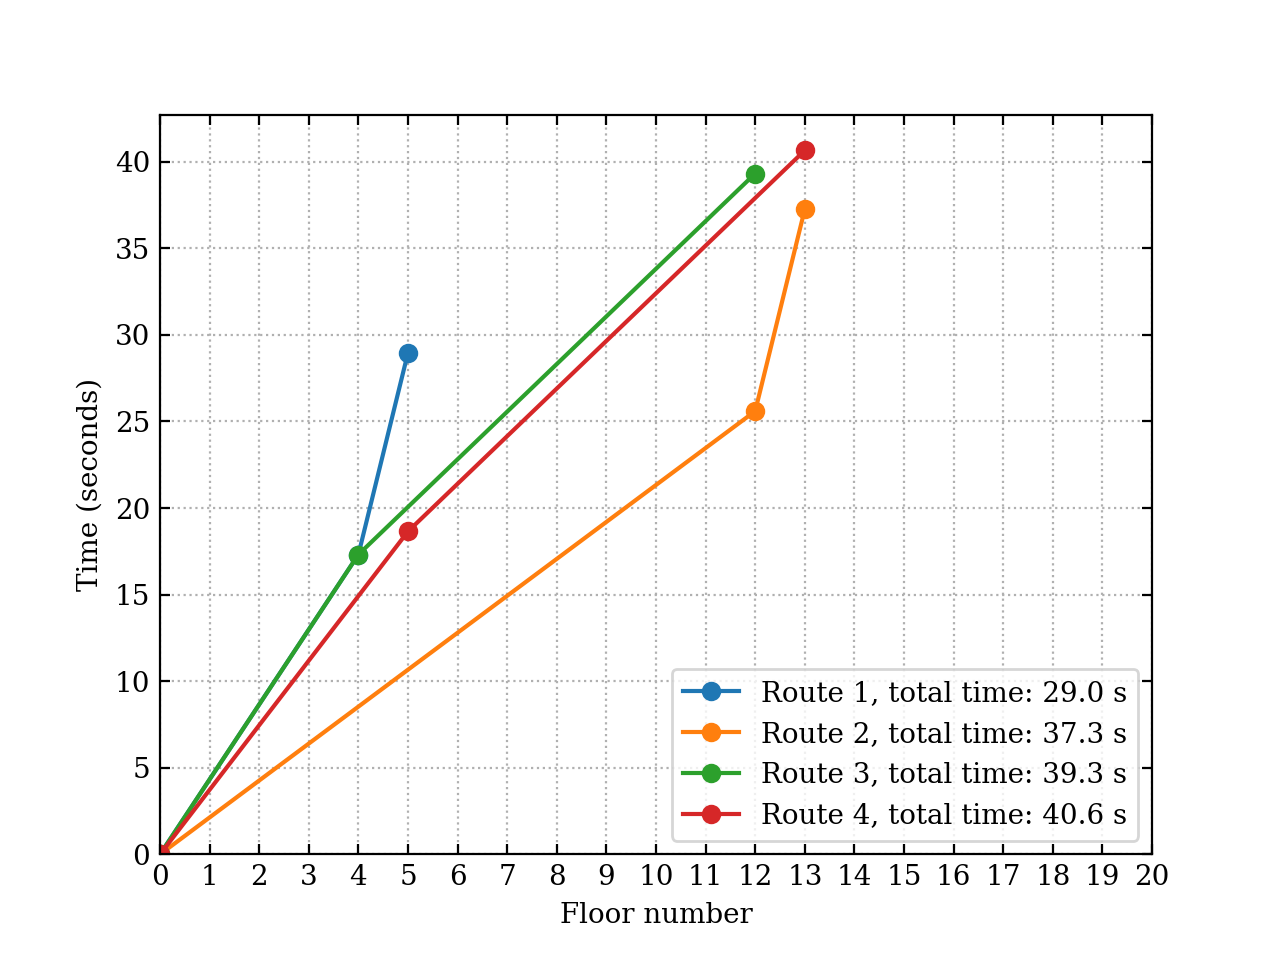

Route 1: 28.97 sec with average travel time 15.43 sec
Route 2: 37.25 sec with average travel time 20.95 sec
Route 3: 39.31 sec with average travel time 18.88 sec
Route 4: 40.65 sec with average travel time 19.77 sec
Average time of route 1 & 2: 27.283 sec
Average time of route 3 & 4: 28.981 sec


In [4]:
# routes = [[0,  5, 10, 15, 20],
#           [0, 17, 18, 19, 20],
#           [0,  1,  3, 19, 20]]

routes = [[0,  4,  5],
          [0, 12, 13],
          [0,  4, 12],
          [0,  5, 13]]

rct = [lift.comp_travel(r) for r in routes]
llabels = []

route_passenger_times = []

newfigure()

for i, r in enumerate(routes):
    
    rct = lift.comp_travel(r)
    route_passenger_times.append(rct[1:])
    print("Route {:d}: {:5.2f} sec with average travel time {:.2f} sec".format(i+1, rct[-1], np.mean(rct)))
    
    plt.plot(r, rct, '-o')
    llabels.append("Route {:}, total time: {:.1f} s".format(i+1, rct[-1]))

plt.ylabel("Time (seconds)")
plt.xlabel("Floor number")
plt.xticks(range(0, 21))
plt.xlim(0,20)
plt.ylim(0)
plt.legend(llabels)
plt.show()
plt.savefig('output/comp_travel.png')

print("Average time of route 1 & 2: {:.3f} sec".format(np.mean(route_passenger_times[0:2])))
print("Average time of route 3 & 4: {:.3f} sec".format(np.mean(route_passenger_times[2:])))

# Analysis

This graph showed us that bundling destination floors together can actually result in a lower average travel time per user. Importantly, for future reference, *route 1* would result in an lift becoming available significantly sooner than any alternative.

# Testing a greed allocation algorithm

- Pass in a list of users, represented as their destination floor number.
- The arrive through a single allocation keypad.
- There will be 20 users, each going to a different random floor from a 30 storey building

- Now I'll try to pass in a list of users, represented as the floor number they want to go to. 
- They arrive in an order and enter their floor one by one so a list is suitable input.
- The first list of users will be a group of 20, each wanting to go to a different floor in a 30 story building.
- Each lift will take one user at a time.
- Greedy algorithm will assign to first available lift.


In [5]:
# test specific parameters
n_users = 20
n_floors = 30
n_lifts = 8

users = list(range(1,n_floors+1))

print("Created a list of {:} users".format(len(users)))
print("Removing {} users from the list".format(n_floors-n_users))

for i in range(n_floors-n_users):
    randuser = random.randint(0, len(users)-1)
    del users[randuser]

print("Shuffling order of the users".format(len(users)))
random.shuffle(users)
print(users)

# create the lift struct
lifts = []
for l in range(n_lifts):
  lifts.append([])

# assign each user to lifts
lift_id = 0
for user in users:
  lifts[lift_id].append(user)
  lift_id = (lift_id+1) % len(lifts)


total_time = 0
lift_times = []
lift_avgs = []
  
print("\nLifts went to the following floors:")
for i, users in enumerate(lifts):
    t = 0
    liftq = users.copy()
    while len(liftq) > 0:
        user = liftq.pop(0)
        waiters = len(liftq)    
        travel = lift.travel_time(user)
        t += travel + 2*waiters*lift.travel_time(user)
  
    lift_times.append(t)
    lift_avgs.append(t/len(users))
    print("  Lift {0:} traveled for {2:4.0f} seconds, with average user time of {3:3.0f} secs/user, and went to floors: {1:}".format(i, users, t, t/len(users)))

total_time = sum(lift_times)
print("\nTotal travel time {:.0f} sec with an average travel time of {:.0f} sec/user".format(total_time, mean(lift_avgs)))

Created a list of 30 users
Removing 10 users from the list
Shuffling order of the users
[3, 21, 19, 23, 2, 9, 10, 27, 24, 22, 16, 4, 17, 13, 6, 28, 5, 18, 7, 20]

Lifts went to the following floors:
  Lift 0 traveled for  203 seconds, with average user time of  68 secs/user, and went to floors: [3, 24, 5]
  Lift 1 traveled for  295 seconds, with average user time of  98 secs/user, and went to floors: [21, 22, 18]
  Lift 2 traveled for  263 seconds, with average user time of  88 secs/user, and went to floors: [19, 16, 7]
  Lift 3 traveled for  256 seconds, with average user time of  85 secs/user, and went to floors: [23, 4, 20]
  Lift 4 traveled for   72 seconds, with average user time of  36 secs/user, and went to floors: [2, 17]
  Lift 5 traveled for   95 seconds, with average user time of  48 secs/user, and went to floors: [9, 13]
  Lift 6 traveled for   92 seconds, with average user time of  46 secs/user, and went to floors: [10, 6]
  Lift 7 traveled for  151 seconds, with average u

# Modelling passenger arrival

As seen in literature review, many papers discuss modelling passenger arrival as compound poisson distribution. This however is unnecessarily complex for the purposes of this model. As such, the high fidelity modelling of passenger arrival will be done through a random poisson distribution, and the parameters for this will be controlled by a custom spline fitting on a macro scale.

In [6]:
print("10 min  is = {}".format(10*60))
print("30 min  is = {}".format(30*60))
print("1 hours is = {}".format(60*60))
print("2 hours is = {}".format(60*60*2))

10 min  is = 600
30 min  is = 1800
1 hours is = 3600
2 hours is = 7200


## How to model arrival

To model arrival, a poisson distribution was used to incorporate the stochatic nature of the overall control optimisation problem. To adjust on the density and frequency of arrivals, the poisson distribution takes a single parameter, $\lambda$.

<IPython.core.display.Javascript object>


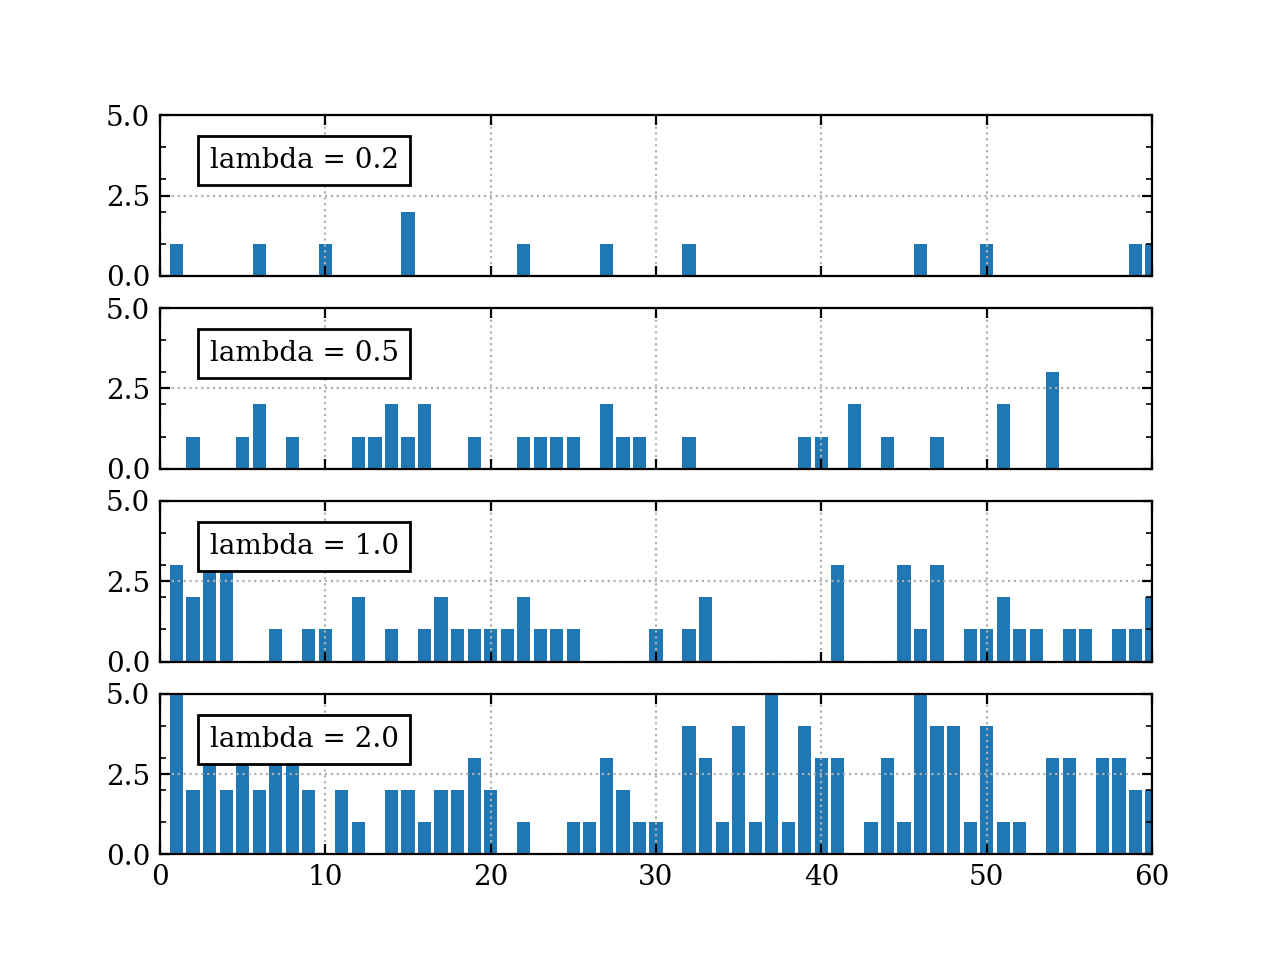

In [7]:
lams = [0.2, 0.5, 1.0, 2.0]
pds = [np.random.poisson(lam=l, size=60) for l in lams]
fig, axarr = plt.subplots(len(lams), sharex=True)
for i, l in enumerate(lams):
    axarr[i].bar(np.arange(1,len(pds[i])+1), pds[i])
    
    m = np.amax(pds)
    axarr[i].set_xlim(0,60)
    axarr[i].set_ylim(0,m)
    axarr[i].set_yticks(np.arange(0,m,1), minor=True)
    
    axarr[i].tick_params(which='both', direction='in', grid_linestyle=":", top=True, right=True)
    axarr[i].grid(which='major', axis='both', linestyle=":")
    axarr[i].text(3, np.amax(pds)-1, 'lambda = {}'.format(l), verticalalignment='top', bbox={'facecolor':'white'})

fig.savefig('output/poisson_comparison.png')

## Analysis

This is indicative on the numerical level required for different time frames.

## Modelling the Lambda parameter

Over the total time period, the lambda parameter must be varied to correctly model building traffic in the morning realistically. The method below utilises control handles to manually alter the overall control spline that will control the lambda parameter.

<IPython.core.display.Javascript object>


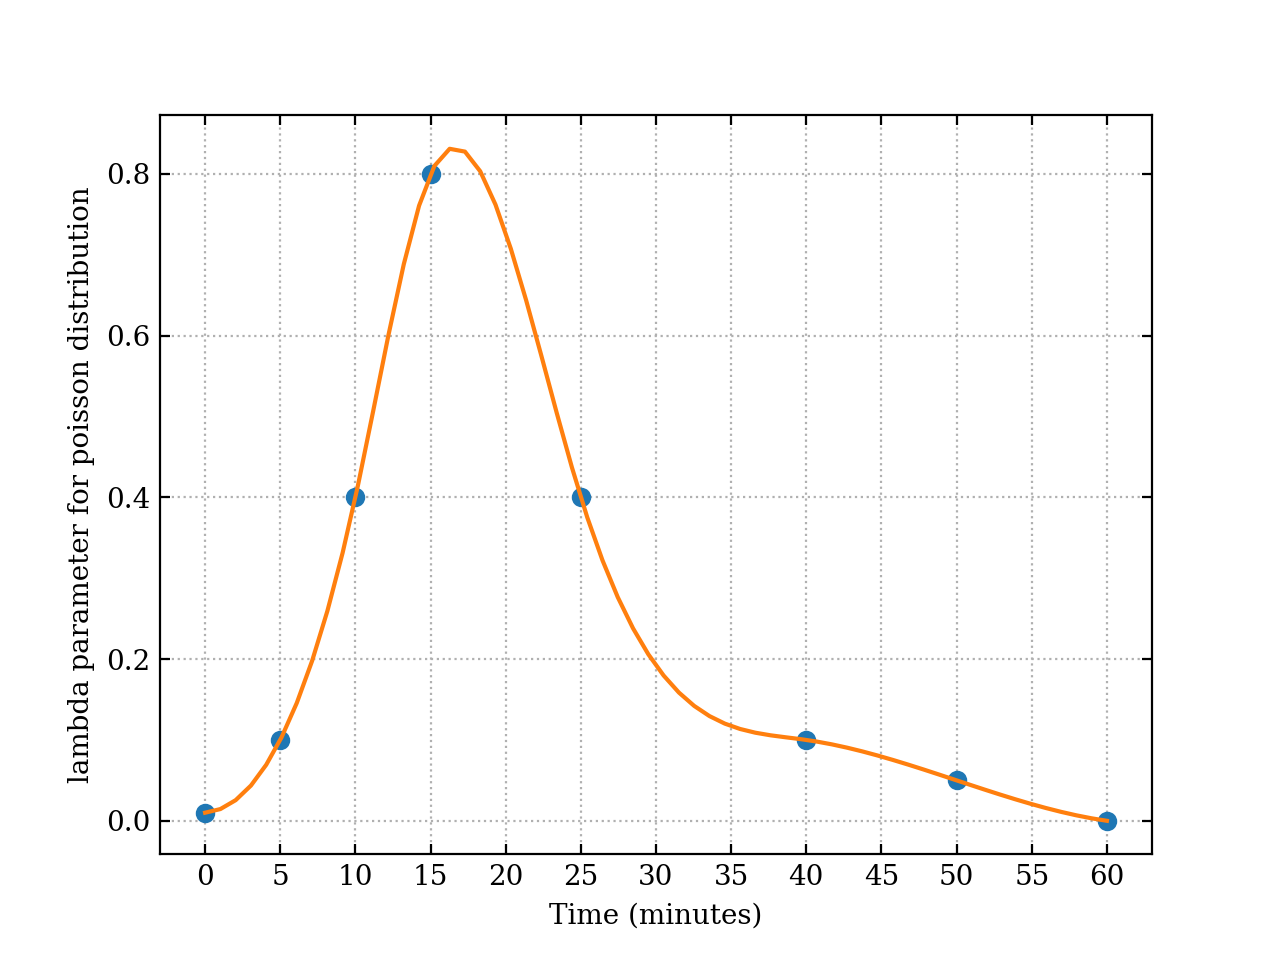

In [8]:
from scipy.interpolate import interp1d

# control handle points
coords = [(0,0.01),
          (5,0.1),
          (10,0.4),
          (15,0.8),
          (25,0.4),
          (40,0.1),
          (50,0.05),
          (60,0.0)]

xf, yf =  zip(*coords)

f = interp1d(xf, yf, kind='cubic')

tpm = time_period//60  # time period in minutes
xnew = np.linspace(0, tpm, num=tpm)
ynew = f(xnew).clip(min=0)

newfigure()
plt.plot(xf, yf, 'o', xnew, ynew, '-')
plt.xlabel('Time (minutes)')
plt.ylabel('lambda parameter for poisson distribution')
# plt.legend(['data', 'linear', 'cubic'], loc='best')

xtn = range(0,tpm+1,5)
xtl = range(0,tpm+1,1*5)
plt.xticks(xtn,xtl)
plt.show()

plt.savefig('output/spline_control.png')

For every 60 second period, sample the control spline, use the value to set as lambda parameter of the poisson distribution. Generate 60 second period of traffic.

<IPython.core.display.Javascript object>


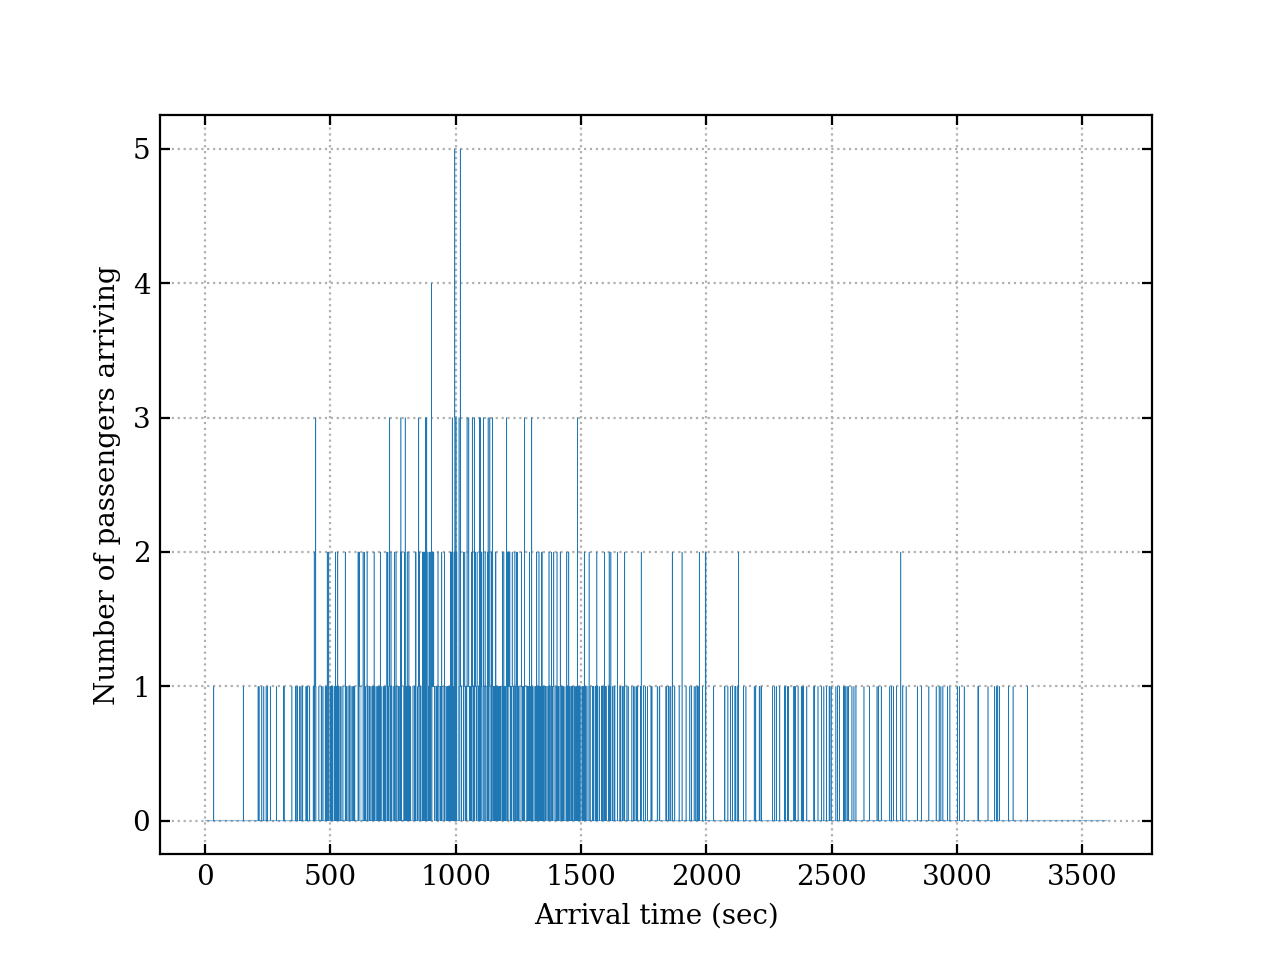

In [9]:
traffic_count = []

for l in ynew:
    traffic_count += np.random.poisson(lam=l, size=tpm).tolist()

newfigure()
plt.step(range(0, len(traffic_count)), traffic_count, linewidth=0.2)
plt.xlabel('Arrival time (sec)')
plt.ylabel('Number of passengers arriving')
plt.savefig('output/traffic_count.png')

## Basic Traffic Analysis and Sanity Check

There are number of metrics that need to be checked to ensure that the traffic makes sense.

Total traffic entering the building: 859
Average number per floor in 50 storey building: 17.18


<IPython.core.display.Javascript object>


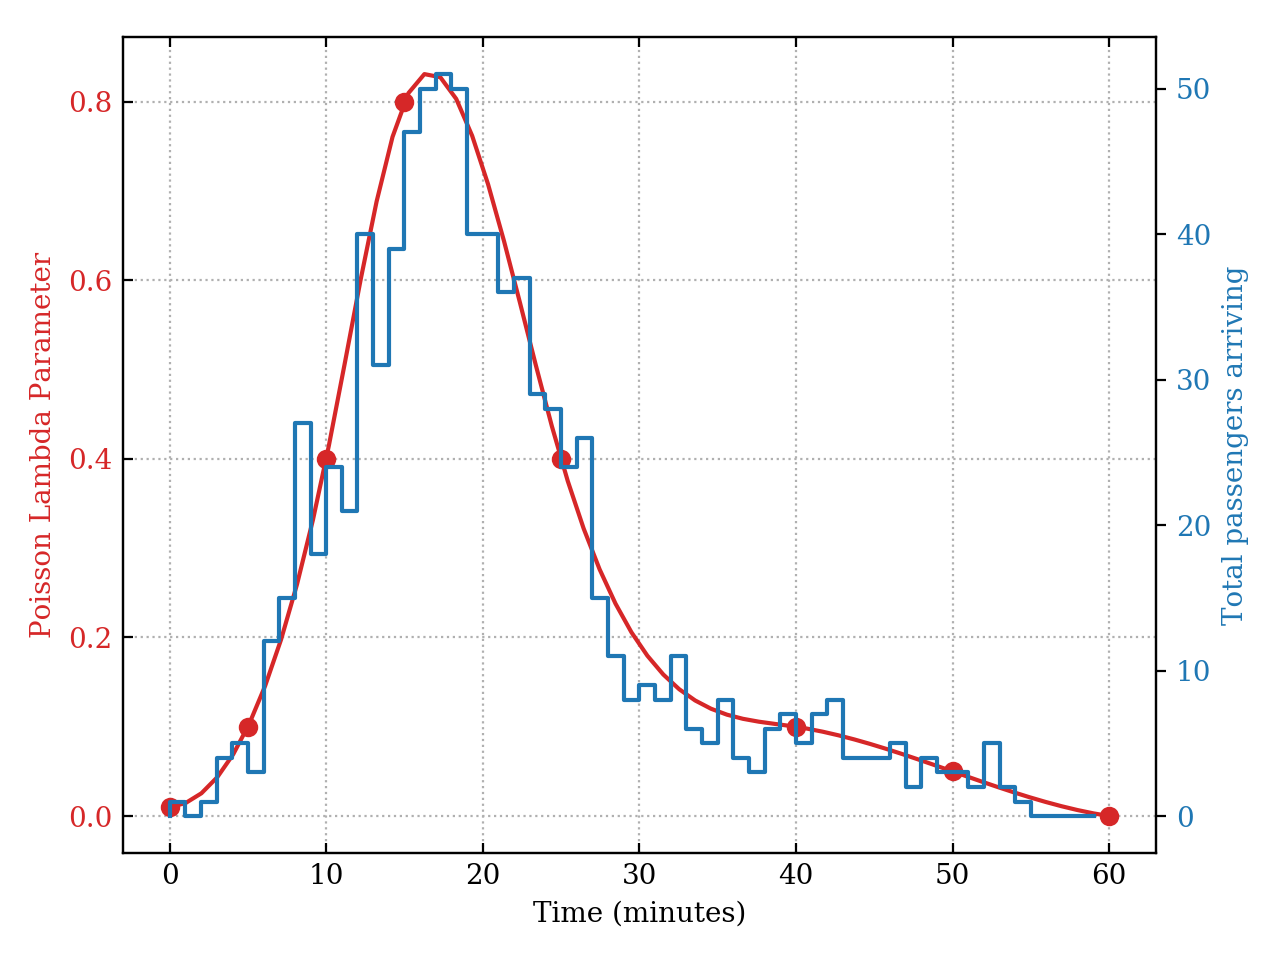

In [10]:
print("Total traffic entering the building: {}".format(sum(traffic_count)))
print("Average number per floor in {} storey building: {}".format(building_n_flr, sum(traffic_count)/building_n_flr))

# GROUP BY THE MINUTE
traffic_by_min = []
v=0
for i, sec in enumerate(traffic_count):
    v += sec
    if i%60==0:
        traffic_by_min.append(v)
        v=0


fig, ax1 = plt.subplots()

ax1.tick_params(direction='in', grid_linestyle=":", top=True, right=True)
ax1.grid(which='major', axis='both', linestyle=":")

color = 'tab:red'
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Poisson Lambda Parameter', color=color)
ax1.plot(xf, yf, 'o', xnew, ynew, '-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Total passengers arriving', color=color)  # we already handled the x-label with ax1
ax2.step(range(0,len(traffic_by_min)), traffic_by_min, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
plt.savefig('output/spline_with_traffic.png')

Now, with the number of passengers set for each second in the total time period, a destination floor must be assigned to each passenger. This should be allocated with equal probability of any destination floor required.

In [11]:
traffic = []
user_id = 0
for timestamp, num_users_per_sec in enumerate(traffic_count):
    for user in range(0,num_users_per_sec):
        
        dest_floor = np.random.randint(1,building_n_flr+1)
        
        user = {'id':user_id,
                'time.start':timestamp,
                'destination':dest_floor}
        traffic.append(user)
        user_id += 1

print("Total size of traffic: {} people".format(len(traffic)))
print("Average traffic flow: {:.3f} people / sec".format(len(traffic)/time_period))

Total size of traffic: 859 people
Average traffic flow: 0.239 people / sec


With the traffic now produced, we can check it to make sure that the floors requested a roughly distributed evenly over time.

<IPython.core.display.Javascript object>


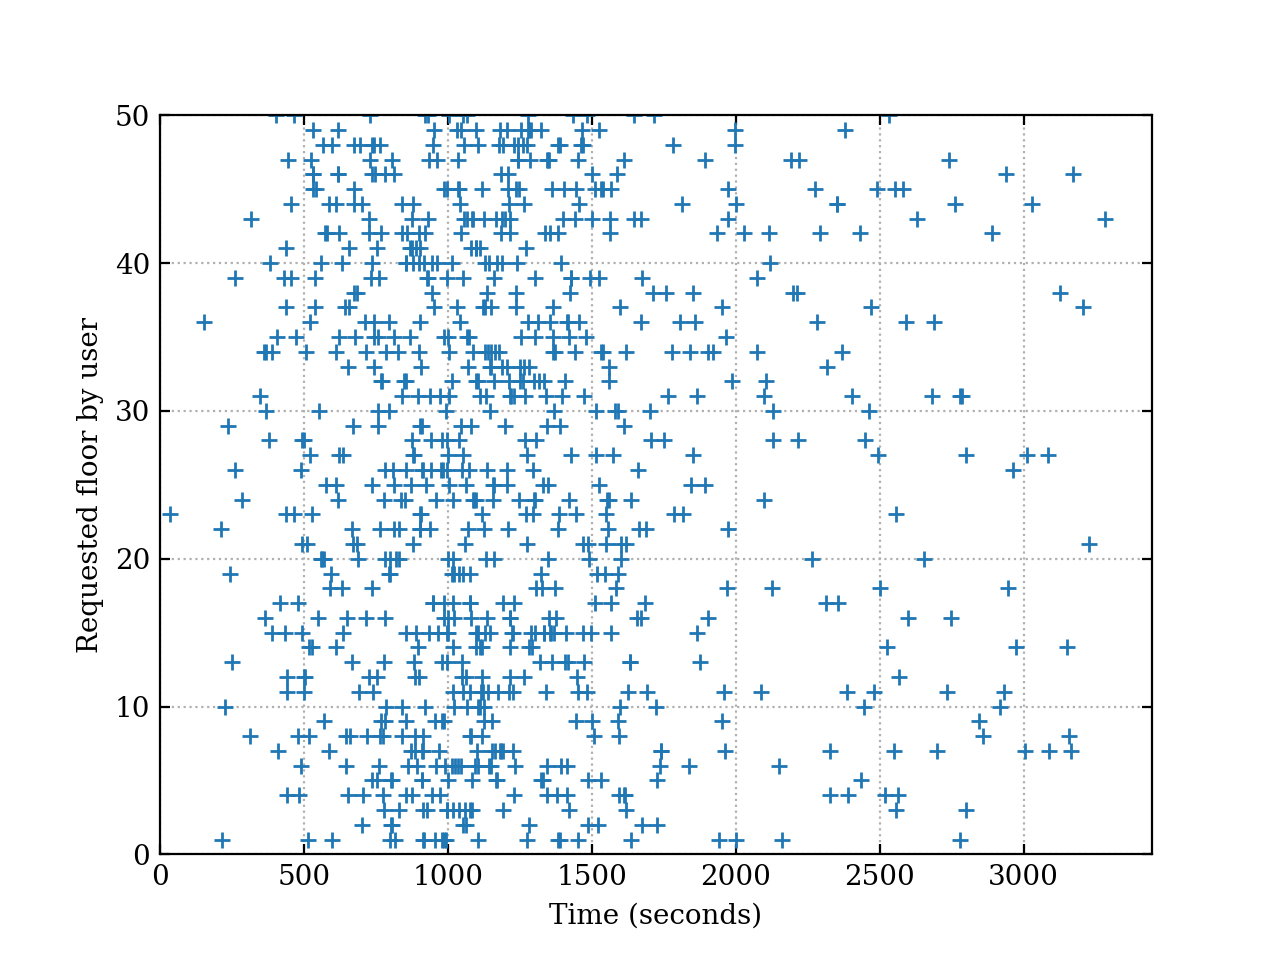

In [12]:
x = [p['time.start'] for p in traffic]
y = [p['destination'] for p in traffic]
newfigure()
plt.plot(x,y,'+')
plt.xlim(0)
plt.ylim(0, building_n_flr)
plt.xlabel('Time (seconds)')
plt.ylabel('Requested floor by user')
plt.savefig('output/reqfloor_time.png')

# Lift System Simulation

In [13]:
import importlib
importlib.reload(subsystem2)

n_iter = 60*60*1

sims = []
algs = ['random','greedy','nearest','grouping','journey','adv grp']

for i, alg in enumerate(algs):
    sim = subsystem2.Simulation(i, iterations=n_iter)
    sim.floors = building_n_flr
    sim.set_traffic(traffic)
    sim.set_assignment_func(alg)
    sim.run()
    sims.append(sim)

All traffic has arrived. Ending simulation early.
┌────────────────────────────────────┐
│ SIMULATION COMPLETE                │
│ Assignment function:      random   │
│ Duration of simulation:   3374     │
│ Maximum duration allowed: 3600     │
│ Total passengers arrived: 859      │
│ Total traffic:            859 (+0) │
│ Percentage processed:     100%     │
└────────────────────────────────────┘
All traffic has arrived. Ending simulation early.
┌────────────────────────────────────┐
│ SIMULATION COMPLETE                │
│ Assignment function:      greedy   │
│ Duration of simulation:   3429     │
│ Maximum duration allowed: 3600     │
│ Total passengers arrived: 859      │
│ Total traffic:            859 (+0) │
│ Percentage processed:     100%     │
└────────────────────────────────────┘
All traffic has arrived. Ending simulation early.
┌────────────────────────────────────┐
│ SIMULATION COMPLETE                │
│ Assignment function:      nearest  │
│ Duration of simulation:   337

<IPython.core.display.Javascript object>


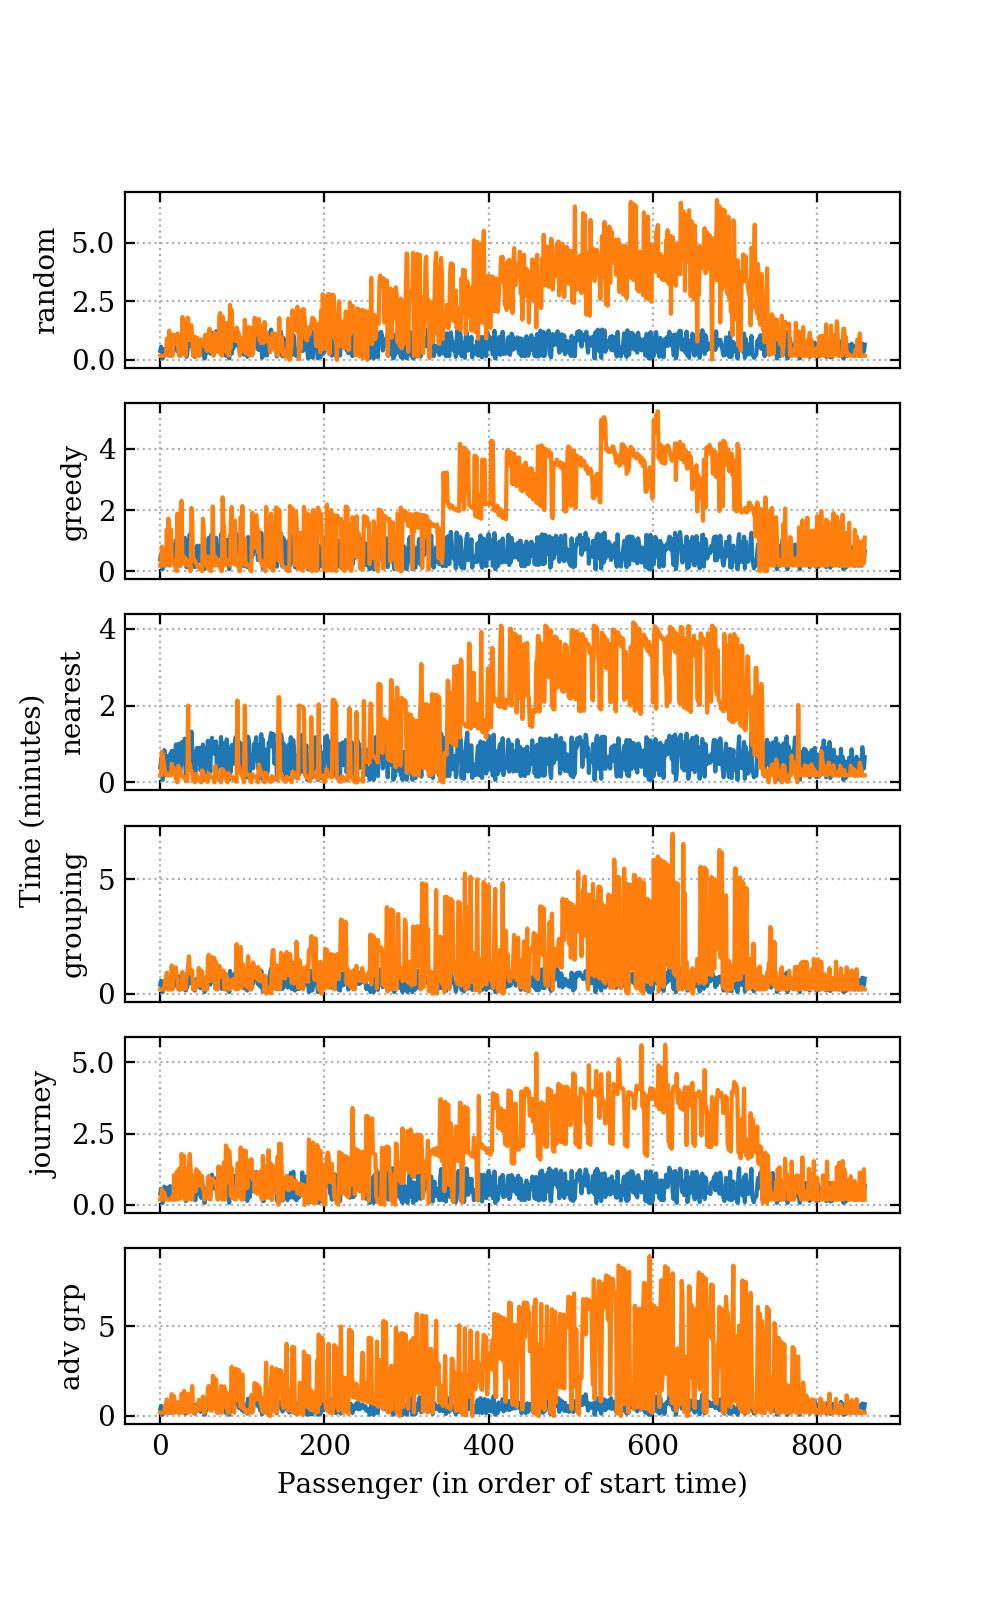

In [14]:
fig, axarr = plt.subplots(len(sims), sharex=True)
all_waittimes = []
all_traveltimes = []
for i, sim in enumerate(sims):
    passenger_data = sorted(sim.arrivals, key=lambda p: p['time.start'])
    waittimes = [p['time.departure']-p['time.lobby'] for p in passenger_data]
    all_waittimes.append(waittimes)
    traveltimes = [p['time.travelling'] for p in passenger_data]
    all_traveltimes.append(traveltimes)
    
    # convert from seconds to minutes
    waittimes = list(map(lambda t: t/60, waittimes))
    traveltimes = list(map(lambda t: t/60, traveltimes))

#     traveltimes.sort()
#     waittimes.sort()
    
    x = range(len(traveltimes))
        
#     axarr[i].plot(x, traveltimes)
    axarr[i].plot(x, traveltimes, x, waittimes)
    axarr[i].tick_params(which='both', direction='in', grid_linestyle=":", top=True, right=True)
    axarr[i].grid(which='major', axis='both', linestyle=":")
    axarr[i].set_ylabel(sim.func_name)

axarr[-1].set_xlabel('Passenger (in order of start time)')
fig.set_size_inches(5, 8)
fig.text(0.02, 0.5, 'Time (minutes)', va='center', rotation='vertical')
fig.savefig('output/alg_travel_wait_comp.png')

<IPython.core.display.Javascript object>


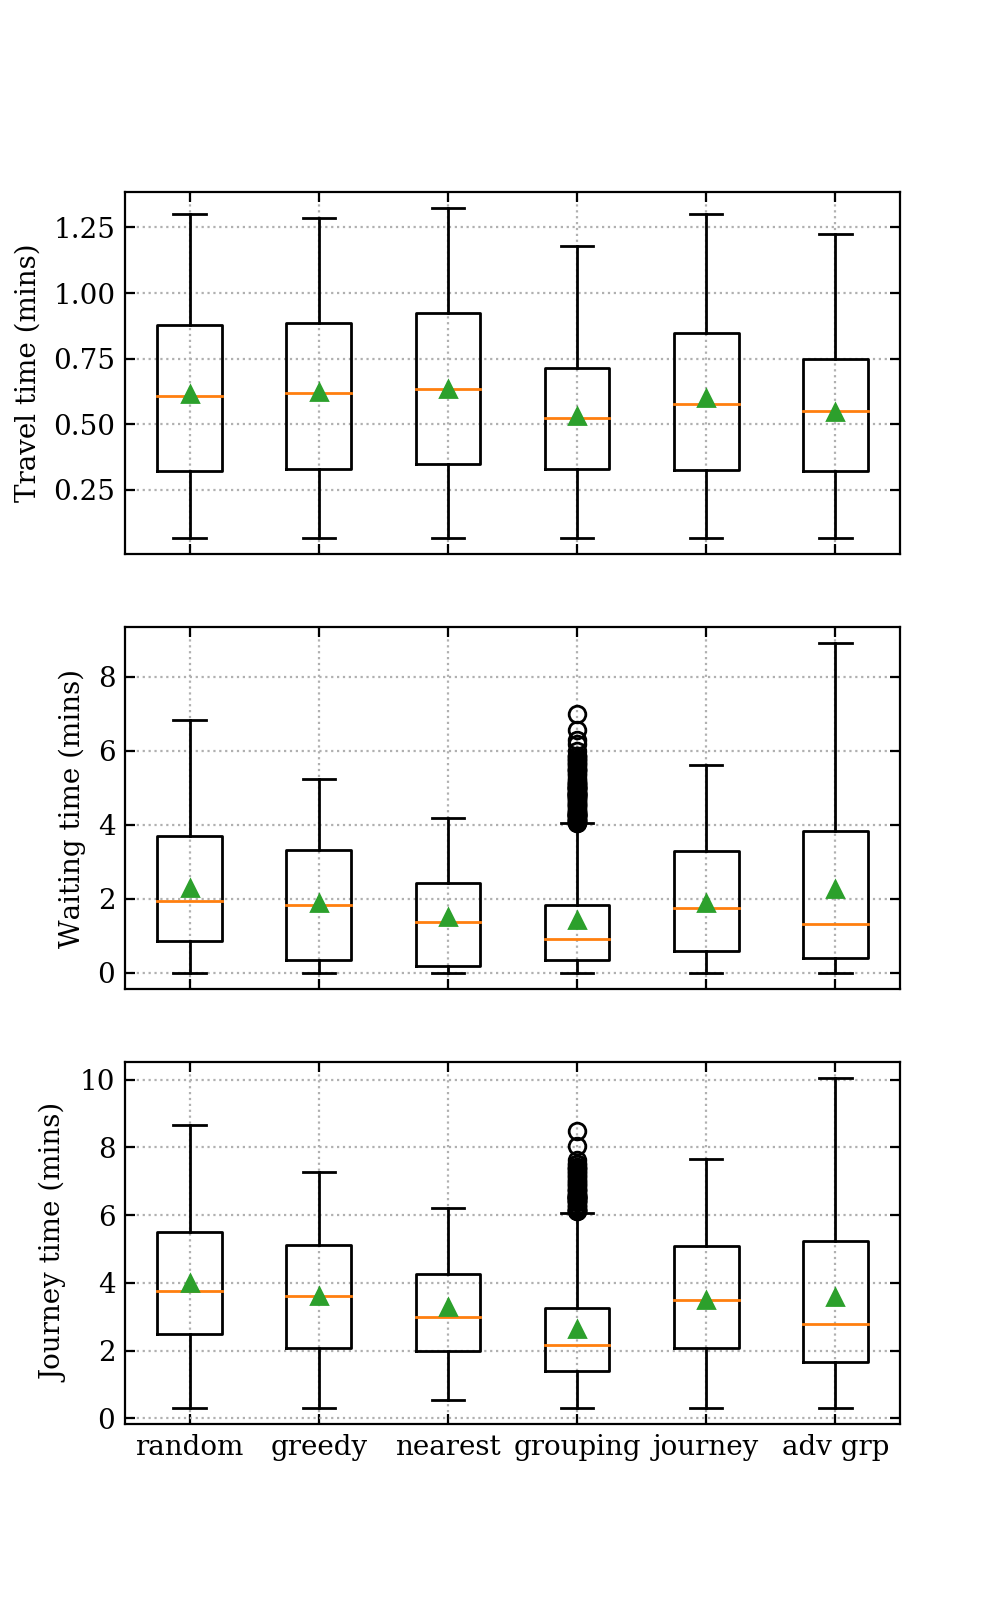

In [15]:
all_wtimes = []
all_ttimes = []
all_jtimes = []
for i, sim in enumerate(sims):
    traveltimes = [p['time.travelling'] for p in sim.arrivals]
    waittimes = [p['time.departure']-p['time.lobby'] for p in sim.arrivals]
    journeytimes = [p['time.arrival']-p['time.lobby'] for p in sim.arrivals]
    
    # convert to minutes
    ttimes = list(map(lambda t: t/60, traveltimes))
    wtimes = list(map(lambda t: t/60, waittimes))
    jtimes = list(map(lambda t: t/60, journeytimes))
    
    # store in combined list
    all_ttimes.append(ttimes)
    all_wtimes.append(wtimes)
    all_jtimes.append(jtimes)

fig, ax = newfigure(nrows=3, sharex=True)
fig.set_size_inches(5, 8)
ax[0].boxplot(all_ttimes, showmeans=True)
ax[0].set_ylabel('Travel time (mins)')
ax[1].boxplot(all_wtimes, showmeans=True)
ax[1].set_ylabel('Waiting time (mins)')
ax[2].boxplot(all_jtimes, showmeans=True)
ax[2].set_ylabel('Journey time (mins)')
ax[2].set_xticklabels(algs)
fig.savefig('output/box_plot_comparison.png')

In [16]:
# fig, ax = newfigure()
# data = []
# for i, sim in enumerate(sims):
#     avg_trvls = []
#     for lift in sim.lifts:
#         avg_trvl = sum(lift.passenger_travel_times)/len(lift.passenger_travel_times)
#         avg_trvls.append(avg_trvl)
        
#     sys_avg = sum(avg_trvls)/len(avg_trvls)
#     data.append(sys_avg)
    
#     plt.bar(i, sys_avg, label='ss')

# xts = range(len(sims))
# xls = [sim.func_name for sim in sims]
# plt.xticks(xts,xls)
# plt.xlabel('Assignment function')
# plt.ylabel('Average Travel Time of Passengers (sec)')
# plt.show()
# fig.savefig('output/bar_chart.png')

In [17]:
tfr = len(traffic)/(30*60)
lfr = 0
print("Average traffic flow rate: {:.3f} p/sec".format(tfr))
print("Average lift flow rate:    {:.3f} p/sec".format(lfr))

Average traffic flow rate: 0.477 p/sec
Average lift flow rate:    0.000 p/sec


<IPython.core.display.Javascript object>


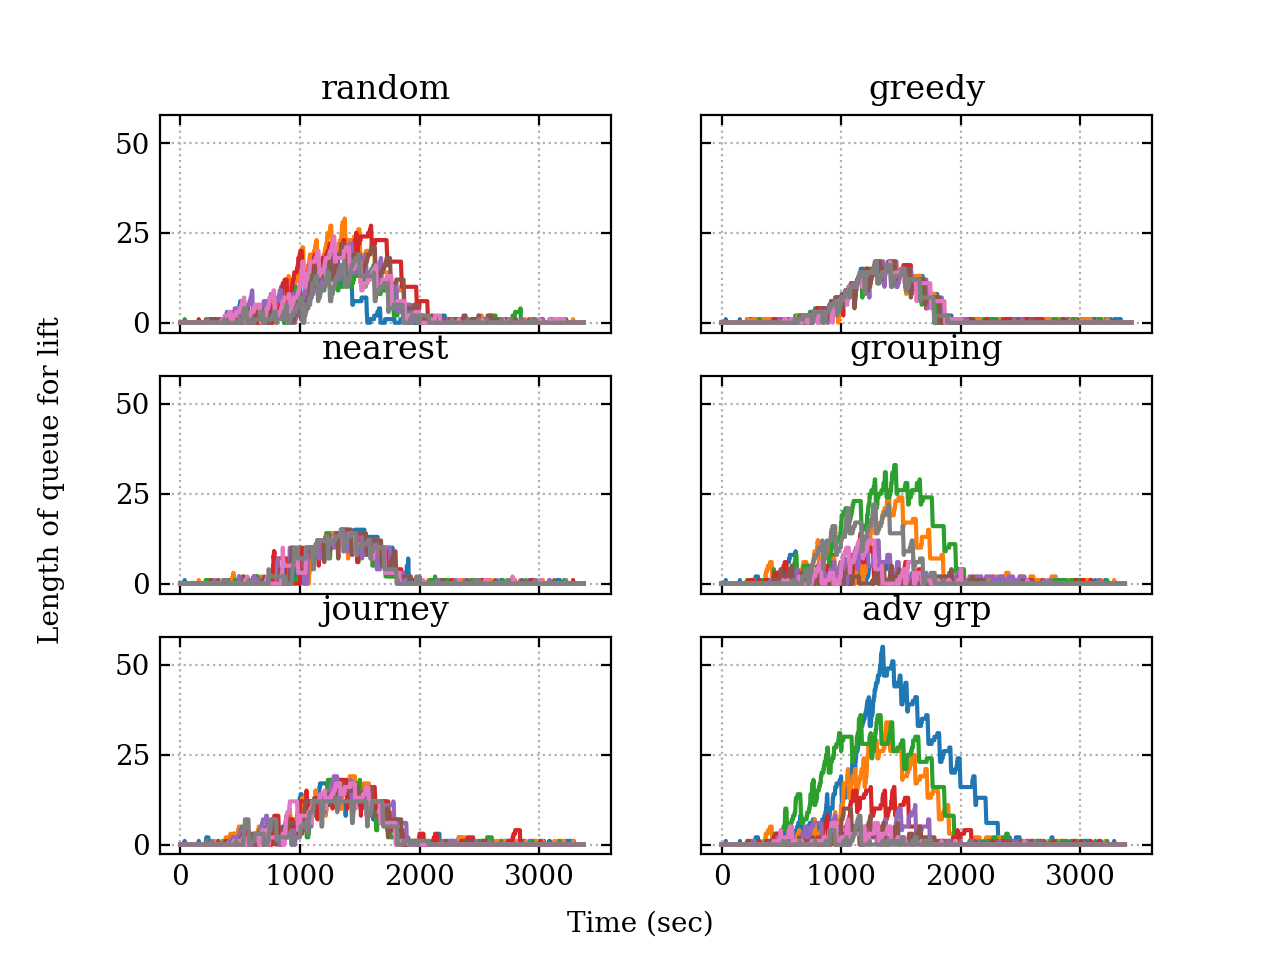

In [18]:
# average waiting time for user

# length of queue of lift against time
fig, ax = newfigure(math.ceil(len(sims)/2),2, sharey=True, sharex=True)
# fig.tight_layout()
for i, sim in enumerate(sims):
    for j, lift in enumerate(sim.lifts):
        fig.axes[i].plot(lift.history['queue_length'])
        fig.axes[i].set_title(sim.func_name)

fig.text(0.03, 0.5, 'Length of queue for lift', va='center', rotation='vertical')
fig.text(0.5, 0.03, 'Time (sec)', ha='center', rotation='horizontal')
fig.savefig('output/queue_length.png')
plt.show()

<IPython.core.display.Javascript object>


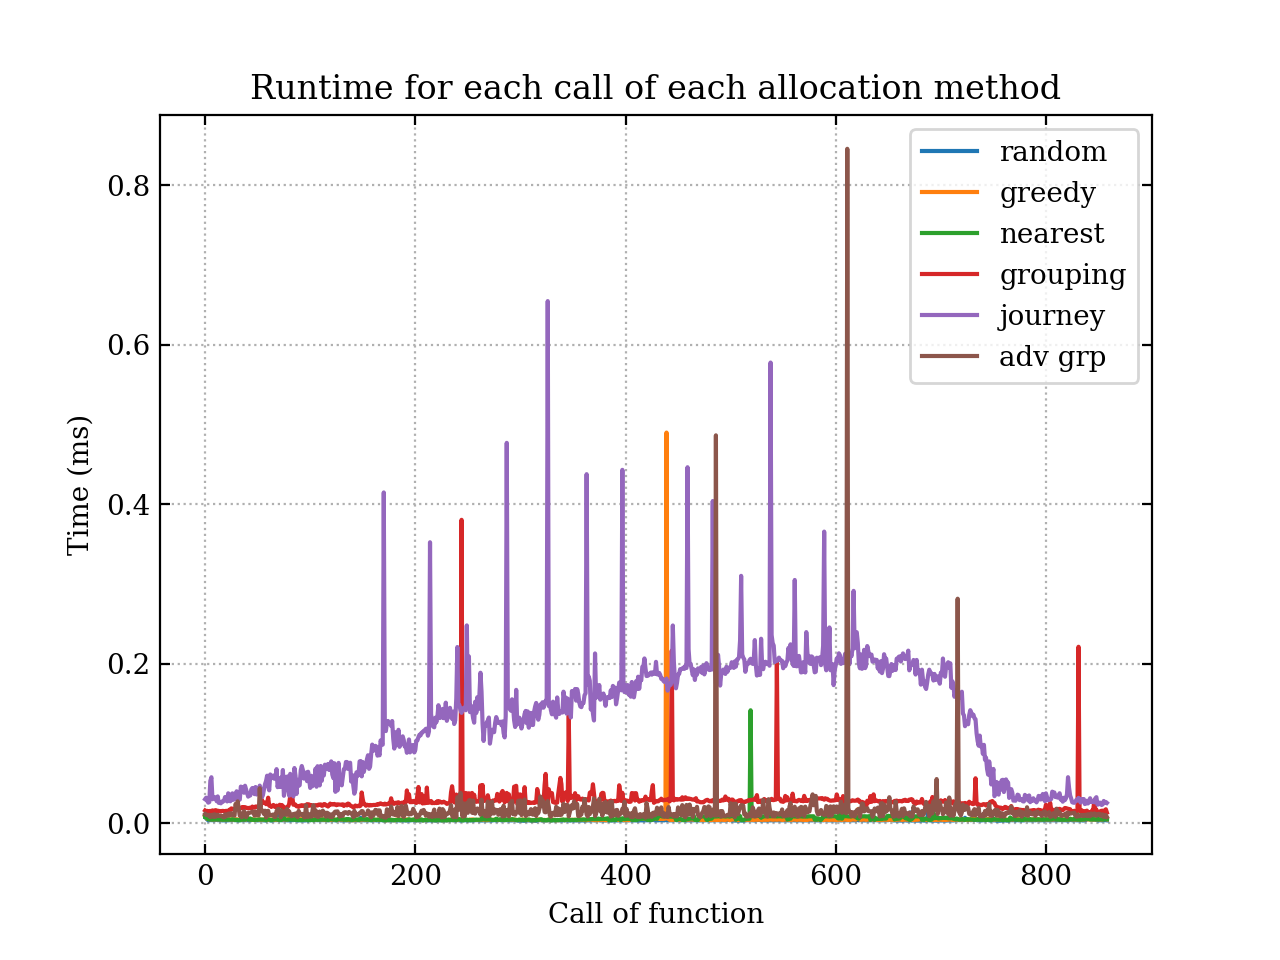

Text(0.5, 0, 'Call of function')

In [19]:
fig, ax = newfigure()
for sim in sims:
    ax.plot(list(map(lambda t:t*1000, sim.assignment_times)))
ax.legend([sim.func_name for sim in sims])
ax.set_title("Runtime for each call of each allocation method")
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Call of function')

In [20]:
print("The notebook takes {:.1f} seconds to execute.".format(timer() - notebook_start_time))

The notebook takes 4.2 seconds to execute.
